# pomegranate and parallelization

pomegranate supports parallelization through a set of built in functions based off of joblib. All computationally intensive functions in pomegranate are implemented in cython with the global interpreter lock (GIL) released, allowing for multithreading to be used for efficient parallel processing. The following functions can be called for parallelization:

1. fit
2. summarize
3. predict
4. predict_proba
5. predict_log_proba
6. log_probability
7. probability

These functions can all be simply parallelized by passing in `n_jobs=X` to the method calls. This tutorial will demonstrate how to use those calls. First we'll look at a simple multivariate Gaussian mixture model, and compare its performance to sklearn. Then we'll look at a hidden Markov model with Gaussian emissions, and lastly we'll look at a mixture of Gaussian HMMs. These can all utilize the build-in parallelization that pomegranate has.

Let's dive right in!

In [1]:
%pylab inline
from sklearn.mixture import GaussianMixture
from pomegranate import *
import seaborn, time
seaborn.set_style('whitegrid')

Populating the interactive namespace from numpy and matplotlib


In [2]:
def create_dataset(n_samples, n_dim, n_classes, alpha=1):
    """Create a random dataset with n_samples in each class."""
    
    X = numpy.concatenate([numpy.random.normal(i*alpha, 1, size=(n_samples, n_dim)) for i in range(n_classes)])
    y = numpy.concatenate([numpy.zeros(n_samples) + i for i in range(n_classes)])
    idx = numpy.arange(X.shape[0])
    numpy.random.shuffle(idx)
    return X[idx], y[idx]

## 1. General Mixture Models

pomegranate has a very efficient implementation of mixture models, particularly Gaussian mixture models. Lets take a look at how fast pomegranate is versus sklearn, and then see how much faster parallelization can get it to be.

In [3]:
n, d, k = 1000000, 5, 3
X, y = create_dataset(n, d, k)

print "sklearn GMM"
%timeit GaussianMixture(n_components=k, covariance_type='full', max_iter=15, tol=1e-10).fit(X)
print 
print "pomegranate GMM"
%timeit GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, k, X, max_iterations=15, stop_threshold=1e-10)
print
print "pomegranate GMM (4 jobs)"
%timeit GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, k, X, n_jobs=4, max_iterations=15, stop_threshold=1e-10)

sklearn GMM


/home/jmschr/anaconda2/lib/python2.7/site-packages/sklearn/mixture/base.py:237: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


1 loop, best of 3: 37 s per loop

pomegranate GMM
1 loop, best of 3: 23.6 s per loop

pomegranate GMM (4 jobs)
1 loop, best of 3: 10.6 s per loop


It looks like on a large dataset not only is pomegranate faster than sklearn at performing 15 iterations of EM on 3 million 5 dimensional datapoints with 3 clusters, but the parallelization is able to help in speeding things up. 

Lets now take a look at the time it takes to make predictions using GMMs. Lets fit the model to a small amount of data, and then predict a larger amount of data drawn from the same underlying distributions.

In [4]:
d, k = 25, 2
X, y = create_dataset(1000, d, k)
a = GaussianMixture(k, n_init=1, max_iter=25).fit(X)
b = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, k, X, max_iterations=25)

In [5]:
del X, y
n = 1000000
X, y = create_dataset(n, d, k)

print "sklearn GMM"
%timeit -n 1 a.predict_proba(X)
print
print "pomegranate GMM"
%timeit -n 1 b.predict_proba(X)
print
print "pomegranate GMM (4 jobs)"
%timeit -n 1 b.predict_proba(X, n_jobs=4)

sklearn GMM
1 loop, best of 3: 2.12 s per loop

pomegranate GMM
1 loop, best of 3: 1.68 s per loop

pomegranate GMM (4 jobs)
1 loop, best of 3: 1.59 s per loop


It looks like pomegranate can be slightly slower than sklearn when using a single processor, but that it can be parallelized to get faster performance. At the same time, predictions at this level happen so quickly (millions per second) that this may not be the most reliable test for parallelization.

To ensure that we're getting the exact same results just faster, lets subtract the predictions from each other and make sure that the sum is equal to 0.

In [6]:
print (b.predict_proba(X) - b.predict_proba(X, n_jobs=4)).sum()

0.0


Great, no difference between the two.

Lets now make sure that pomegranate and sklearn are learning basically the same thing. Lets fit both models to some 2 dimensional 2 component data and make sure that they both extract the underlying clusters by plotting them.

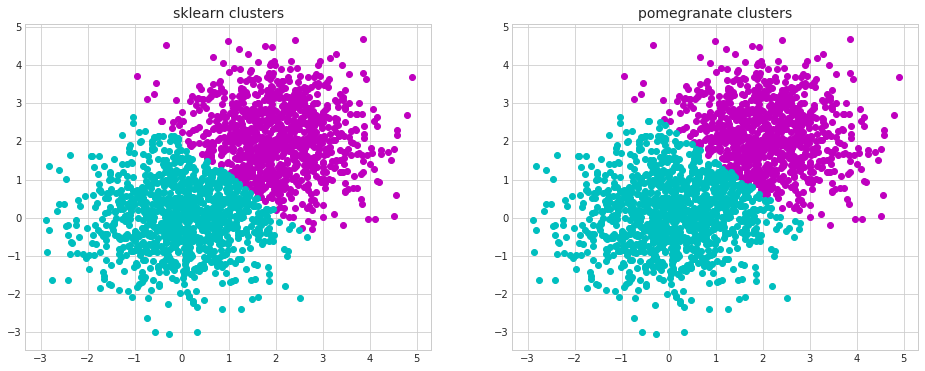

In [7]:
d, k = 2, 2
X, y = create_dataset(1000, d, k, alpha=2)
a = GaussianMixture(k, n_init=1, max_iter=25).fit(X)
b = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, k, X, max_iterations=25)

y1, y2 = a.predict(X), b.predict(X)

plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title("sklearn clusters", fontsize=14)
plt.scatter(X[y1==0, 0], X[y1==0, 1], color='m', edgecolor='m')
plt.scatter(X[y1==1, 0], X[y1==1, 1], color='c', edgecolor='c')

plt.subplot(122)
plt.title("pomegranate clusters", fontsize=14)
plt.scatter(X[y2==0, 0], X[y2==0, 1], color='m', edgecolor='m')
plt.scatter(X[y2==1, 0], X[y2==1, 1], color='c', edgecolor='c')

It looks like we're getting the same basic results for the two. The two algorithms are initialized a bit differently, and so it can be difficult to directly compare the results between them, but it looks like they're getting roughly the same results.

## 3. Multivariate Gaussian HMM

Now let's move on to training a hidden Markov model with multivariate Gaussian emissions with a diagonal covariance matrix. We'll randomly generate some Gaussian distributed numbers and use pomegranate with either one or four threads to fit our model to the data.

In [8]:
X = numpy.random.randn(1000, 500, 50)

print "pomegranate Gaussian HMM (1 job)"
%timeit -n 1 -r 1 HiddenMarkovModel.from_samples(NormalDistribution, 5, X, max_iterations=5)
print
print "pomegranate Gaussian HMM (2 jobs)"
%timeit -n 1 -r 1 HiddenMarkovModel.from_samples(NormalDistribution, 5, X, max_iterations=5, n_jobs=2)
print
print "pomegranate Gaussian HMM (2 jobs)"
%timeit -n 1 -r 1 HiddenMarkovModel.from_samples(NormalDistribution, 5, X, max_iterations=5, n_jobs=4)

pomegranate Gaussian HMM (1 job)
1 loop, best of 1: 22.1 s per loop

pomegranate Gaussian HMM (2 jobs)
1 loop, best of 1: 12.9 s per loop

pomegranate Gaussian HMM (2 jobs)
1 loop, best of 1: 8.37 s per loop


All we had to do was pass in the n_jobs parameter to the fit function in order to get a speed improvement. It looks like we're getting a really good speed improvement, as well! This is mostly because the HMM algorithms perform a lot more operations than the other models, and so spend the vast majority of time with the GIL released. You may not notice as strong speedups when using a MultivariateGaussianDistribution because BLAS uses multithreaded operations already internally, even when only one job is specified.

Now lets look at the prediction function to make sure the we're getting speedups there as well. You'll have to use a wrapper function to parallelize the predictions for a HMM because it returns an annotated sequence rather than a single value like a classic machine learning model might.

In [9]:
model = HiddenMarkovModel.from_samples(NormalDistribution, 5, X, max_iterations=2, verbose=False)

print "pomegranate Gaussian HMM (1 job)"
%timeit predict_proba(model, X)
print
print "pomegranate Gaussian HMM (2 jobs)"
%timeit predict_proba(model, X, n_jobs=2)

pomegranate Gaussian HMM (1 job)
1 loop, best of 3: 3.22 s per loop

pomegranate Gaussian HMM (2 jobs)
1 loop, best of 3: 1.93 s per loop


Great, we're getting a really good speedup on that as well! Looks like the parallel processing is more efficient with a bigger, more complex model, than with a simple one. This can make sense, because all inference/training is more complex, and so there is more time with the GIL released compared to with the simpler operations.

## 4. Mixture of Hidden Markov Models

Let's stack another layer onto this model by making it a mixture of these hidden Markov models, instead of a single one. At this point we're sticking a multivariate Gaussian HMM into a mixture and we're going to train this big thing in parallel.

In [13]:
def create_model(mus):
    n = mus.shape[0]
    
    starts = numpy.zeros(n)
    starts[0] = 1.
    
    ends = numpy.zeros(n)
    ends[-1] = 0.5
    
    transition_matrix = numpy.zeros((n, n))
    distributions = []
    
    for i in range(n):
        transition_matrix[i, i] = 0.5
        
        if i < n - 1:
            transition_matrix[i, i+1] = 0.5
    
        distribution = IndependentComponentsDistribution([NormalDistribution(mu, 1) for mu in mus[i]])
        distributions.append(distribution)
    
    model = HiddenMarkovModel.from_matrix(transition_matrix, distributions, starts, ends)
    return model
    

def create_mixture(mus):
    hmms = [create_model(mu) for mu in mus]
    return GeneralMixtureModel(hmms)

n, d = 50, 10
mus = [(numpy.random.randn(d, n)*0.2 + numpy.random.randn(n)*2).T for i in range(2)]

In [14]:
model = create_mixture(mus)
X = numpy.random.randn(400, 150, d)

print "pomegranate Mixture of Gaussian HMMs (1 job)"
%timeit model.fit(X, max_iterations=5)
print

model = create_mixture(mus)
print "pomegranate Mixture of Gaussian HMMs (2 jobs)"
%timeit model.fit(X, max_iterations=5, n_jobs=2)

pomegranate Mixture of Gaussian HMMs (1 job)
1 loop, best of 3: 3 s per loop

pomegranate Mixture of Gaussian HMMs (2 jobs)
1 loop, best of 3: 1.83 s per loop


Looks like we're getting a really nice speed improvement when training this complex model. Let's take a look now at the time it takes to do inference with it.

In [15]:
model = create_mixture(mus)

print "pomegranate Mixture of Gaussian HMMs (1 job)"
%timeit model.predict_proba(X)
print

model = create_mixture(mus)
print "pomegranate Mixture of Gaussian HMMs (2 jobs)"
%timeit model.predict_proba(X, n_jobs=2)

pomegranate Mixture of Gaussian HMMs (1 job)
1 loop, best of 3: 598 ms per loop

pomegranate Mixture of Gaussian HMMs (2 jobs)
1 loop, best of 3: 411 ms per loop


We're getting a good speed improvement here too through parallelization.

## Conclusions

Hopefully you'll find pomegranate useful in your work! Parallelization should allow you to train complex models faster than before. Keep in mind though that there is an overhead to using parallel processing, and so it's possible that on some smaller examples it does not work as well. In general, the bigger the dataset, the closer to a linear speedup you'll get with pomegranate.

If you have any interesting examples of how you've used pomegranate in your work, I'd love to hear about them. In addition I'd like to hear any feedback you may have on features you'd like to see. Please shoot me an email. Good luck!